In [ ]:
# Uncomment if necessary

In [1]:
#!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

In [ ]:
#!pip install altair

In [2]:
import h2o
from h2o.estimators import (
    H2OGeneralizedLinearEstimator, 
    H2ORandomForestEstimator, 
    H2OGradientBoostingEstimator, 
    H2ONaiveBayesEstimator,
    H2OStackedEnsembleEstimator,
    H2ODeepLearningEstimator

)
from h2o.frame import H2OFrame
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)
  Starting server from D:\Archivos de programa\Anaconda3\envs\Master_1\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\david\AppData\Local\Temp\tmp73tmtmmz
  JVM stdout: C:\Users\david\AppData\Local\Temp\tmp73tmtmmz\h2o_david_started_from_python.out
  JVM stderr: C:\Users\david\AppData\Local\Temp\tmp73tmtmmz\h2o_david_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Paris
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,2 months and 4 days
H2O_cluster_name:,H2O_from_python_david_9k1xw8
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.979 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### GLOBAL PRESETS

In [696]:
import warnings
warnings.filterwarnings('ignore')

TEST_SIZE = 0.2

Throughout the project we reference many times the paper: **Practical considerations for specifying a super learner**
https://arxiv.org/pdf/2204.06139

### DATA LOADING AND PREPROCESSING

In [4]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd

In [865]:
spam_data = fetch_openml(data_id=44, as_frame=True)
spam_df = spam_data.frame

X = spam_df.iloc[:, :-1]  # All columns except the last are features
y = spam_df.iloc[:, -1]   # The last column is the target (spam or not)


y = y.astype(int)

# Split the dataset into training (80%) and testing (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# We split the temporary dataset into training (80%) and validation (20% of temp, i.e., 10% of total)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Convert to H2O Frames
h2o_train = H2OFrame(pd.DataFrame(X_train).assign(label=y_train.values))
h2o_val = H2OFrame(pd.DataFrame(X_val).assign(label=y_val.values))
h2o_test = H2OFrame(pd.DataFrame(X_test).assign(label=y_test.values))

# Convert target columns to categorical
h2o_train['label'] = h2o_train['label'].asfactor()
h2o_val['label'] = h2o_val['label'].asfactor()
h2o_test['label'] = h2o_test['label'].asfactor()

# Verify the splits
print("Training set size:", h2o_train.nrows)
print("Validation set size:", h2o_val.nrows)
print("Testing set size:", h2o_test.nrows)
# Example of dataset
X.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Training set size: 2944
Validation set size: 736
Testing set size: 921


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,word_freq_conference,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191


## Data Analysis

The dataset consists of 58 columns

+ 48 columns with the name `words_freq_${WORD}` that indicate the **percentage** (not the frequency but the normalized frequency in the range 0 to 100) of the words in the document that were said word.
+ 6 columns with the name `char_freq_${ASCII_CODE}` that indicates the **percentage** of the characters that the character corresponding to that ascii code accounts for.
+ 3 columns with the name `capital_run_length_${METRIC}` that indicate the value of that metric for consecutive sequences of capital letters.
+ 1 column with the name `type` that indicates wether the message was spam or not.

For more detailed information you can go to the [original dataset](https://archive.ics.uci.edu/dataset/94/spambase) from the machine learning repository.  

In [6]:
with pd.option_context('display.max_columns', None):
    display(X.describe())

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_%3B,char_freq_%28,char_freq_%5B,char_freq_%21,char_freq_%24,char_freq_%23,capital_run_length_average,capital_run_length_longest,capital_run_length_total
count,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000,4601.000000
mean,0.104553,0.213015,0.280656,0.065425,0.312223,0.095901,0.114208,0.105295,0.090067,0.239413,0.059824,0.541702,0.093930,0.058626,0.049205,0.248848,0.142586,0.184745,1.662100,0.085577,0.809761,0.121202,0.101645,0.094269,0.549504,0.265384,0.767305,0.124845,0.098915,0.102852,0.064753,0.047048,0.097229,0.047835,0.105412,0.097477,0.136953,0.013201,0.078629,0.064834,0.043667,0.132339,0.046099,0.079196,0.301224,0.179824,0.005444,0.031869,0.038575,0.139030,0.016976,0.269071,0.075811,0.044238,5.191515,52.172789,283.289285
std,0.305358,1.290575,0.504143,1.395151,0.672513,0.273824,0.391441,0.401071,0.278616,0.644755,0.201545,0.861698,0.301036,0.335184,0.258843,0.825792,0.444055,0.531122,1.775481,0.509767,1.200810,1.025756,0.350286,0.442636,1.671349,0.886955,3.367292,0.538576,0.593327,0.456682,0.403393,0.328559,0.555907,0.329445,0.532260,0.402623,0.423451,0.220651,0.434672,0.349916,0.361205,0.766819,0.223812,0.621976,1.011687,0.911119,0.076274,0.285735,0.243471,0.270355,0.109394,0.815672,0.245882,0.429342,31.729449,194.891310,606.347851
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.588000,6.000000,35.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.310000,0.000000,0.220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,

From this plot we see that for both frequency variables, the values are in most cases 0, as in almost all but `will`, `you`, `your` and `+` are the only ones were the median is above zero and even at the 75 percentile only eleven have nonzero values.

In [7]:
from matplotlib import pyplot as plt
import numpy as np

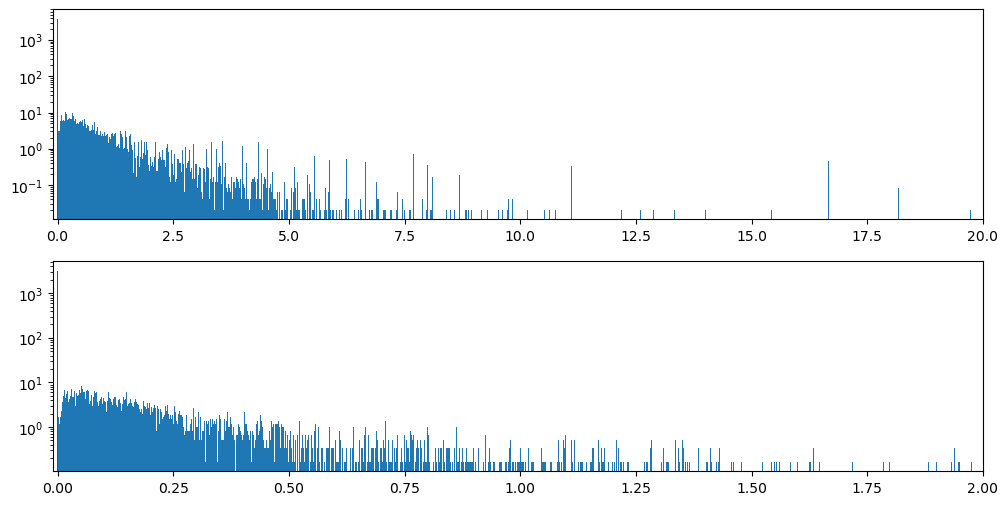

In [8]:
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

words = spam_df[[col for col in spam_df.columns if col.startswith("word_freq")]].to_numpy()
index, count = np.unique(words, return_counts=True)
ax1.bar(index, count / words.shape[1], width=0.01)
ax1.bar(index[0], count[0] / words.shape[1], width=0.01, color="red")
ax1.set_yscale("log")
ax1.set_xlim(-0.1, 20)
chars = spam_df[[col for col in spam_df.columns if col.startswith("char_freq")]].to_numpy()
index, count = np.unique(chars, return_counts=True)
ax2.bar(index, count / chars.shape[1], width=0.001)
ax2.bar(index[0], count[0] / chars.shape[1], width=0.001, color="red")
ax2.set_yscale("log")
ax2.set_xlim(-0.01, 2)
plt.show()

Checking the distribution of the values of word frequencies (top) and character frequencies (bottom), we can see more clearly the spike at zero (in red). With the full distribution shown, see the different behaviour at zero (a spike) and after zero (an exponentail decay), this means that the disribution of the variables is a mixture of a discrete and continuous variable. Another notable fact is that for the characters the rate for the exponential decay is faster than for words.

In [9]:
from sklearn.ensemble import RandomForestClassifier

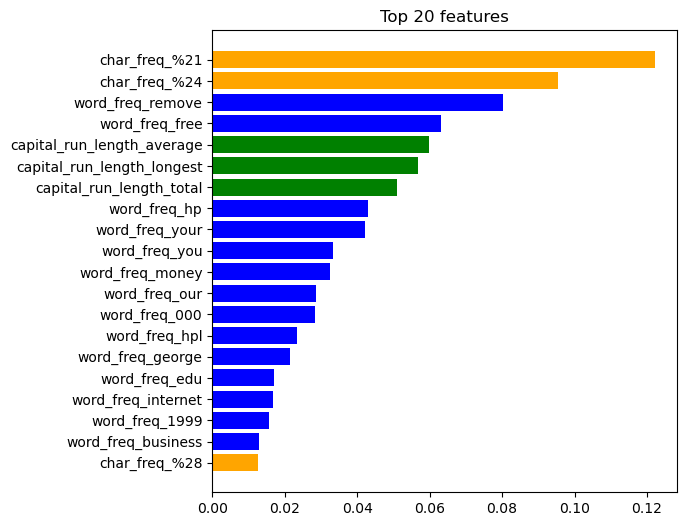

In [15]:
rf = RandomForestClassifier(random_state=42)
rf.fit(spam_data.data, spam_data.target)
importance = rf.feature_importances_
order = np.argsort(importance)
names = spam_data.data.columns
colors = np.array(["blue"] * 48 + ["orange"] * 6 + ["green"] * 3)

plt.figure(figsize=(6, 6))
plt.barh(names[order[-20:]], importance[order[-20:]], color=colors[order[-20:]])
plt.title("Top 20 features")
plt.show()

Measuring the importance of the features using a random forest, we get that the two most important features are the characters `!` (%21) and `$` (%24) respectively, then followed by the words `remove` and `free`, After that come all three variables about capitalization, followed then by a list of words.

With this we see that almost half of the most important variables fall in the captegories of:
+ Highlighting or emphasizing: the character `!` and writting in capital letters
+ Money: the character `$`, the words `free`, `money`, `000` (probably as part of £1.000 separated by the parser) or `buisness`

This two categories are two of the main components of scam emails for the time the dataset was made (1999), for the importance of what the contents of the email entailed and the oportinity of making money by previously paying a little bit.

#### Is SPAM class underepresented?

In [649]:
class_1 = len(spam_df[spam_df['class'] == '1'])
class_0 = len(spam_df[spam_df['class'] == '0'])
print(f"Records containing spam: {class_1}")
print(f"Records not containing spam: {class_0}")

Records containing spam: 1813
Records not containing spam: 2788


#### Computing the effective sample size n_eff (from paper)

We have binary data, the prevalence of Y is **p=class_1 / total_size**, subsequently **n_rare=n*min(p, 1-p)**, and finally **n_eff=min(n, 5*n_rare)** 

In [668]:
n = len(spam_df)

p = class_1 / n
n_rare = n * min(p, 1-p)
n_eff = min(n, 5*n_rare)
n_eff

4601

#### Computing the V for V-fold cross-validation
Since n_eff >= 500 but not >= 5000 we should select a value between 20 and 10. We take in account that n_eff is closer to 5000 and so we focus on V slightly higher than 10.

In [698]:
N_FOLDS = 12

### BASE LEARNERS - SPECIFICATION

When choosing the base learners for the first layer we have considered the properties of the dataset and the task in this case being binary classification. As the paper *Practical considerations for specifying a super learner* suggests "An ideal, rich library is diverse in its learning strategies, able to adapt to a range of underlying functional forms for the true prediction function, computationally feasible, and effective at handling high dimensional data. Diverse libraries include parametric learners, highly data-adaptive learners, multiple variants of the same learner with different tuning parameter specifications...". So the first layer should consist of diverse algorithms with different inductive biases to ensure a rich set of predictions for the metalearnerearner".

We have selected: 

**Random Forest:**

Because they are robust to overfitting on datasets with many features and they handle noisy or irrelevant features well, which is can be a thing in this case.

**Generalized Linear Model - Logistic regression:**

We chose to add it because it's a simple yet effective baseline model, especially logistic regression for binary classification. It should provide a low-variance learner to complement the other high-variance ones.

**Deep Learning (H20's MLP):**

We add the neural networks, because of it's flexibility so it could capture non-linear relationships which should broaden the diversity of the stacks prediction.

**Naive Bayes:**

Why: Spam datasets often benefit from Naive Bayes since it assumes independence among features and thus might capture something more general than the other models.

**Gradient Boosting Machines:**

We choose them as another complement ensemble method that can capture rather complex relationship and so maybe overfit more to th data.


We assume the simpler models like naive bayes and logistic regression should bring in the stack a more general view without focusing too much on the quirks in the data and to balance it out we have selected a more accurate and flexible methods like MLP

Also we try various configurations of hyperparameters for each class of learners as the paper specifies: *"Since the true functional form is unknown, it is a good idea to consider a variety of base learners, and to construct multiple variations of the same base learner with different tuning specifications. There is no harm in including a learner that performs poorly in the library, as it will be given a weight of zero..."* (or close to 0).

In [443]:
base_learners_simple01 = {
    "LogisticRegression": H2OGeneralizedLinearEstimator(family="binomial", nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True),
    "RandomForest": H2ORandomForestEstimator(ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True),
    "GradientBoosting": H2OGradientBoostingEstimator(ntrees=50, max_depth=5, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True),
    "NaiveBayes": H2ONaiveBayesEstimator(nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True)
}

# TODO consider balance_class=True

base_learners_mix_duplicates01 = {
    "LogisticRegression_binomial": H2OGeneralizedLinearEstimator(
        family="binomial", nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "RandomForest_50trees": H2ORandomForestEstimator(
        ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "RandomForest_50trees_unbounded_D": H2ORandomForestEstimator(
        ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "RandomForest_10trees": H2ORandomForestEstimator(
        ntrees=10, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "RandomForest_10trees_unbounded_D": H2ORandomForestEstimator(
        ntrees=10, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "GradientBoosting": H2OGradientBoostingEstimator(
        ntrees=50, max_depth=5, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True, balance_classes=True
    ),
    "NaiveBayes": H2ONaiveBayesEstimator(
        nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "NeuralNetwork_32": H2ODeepLearningEstimator(
        hidden=[32], epochs=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "NeuralNetwork_32_16": H2ODeepLearningEstimator(
        hidden=[32, 16], epochs=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    )
}

base_learners_mix_rf_nns_01 = {
    "LogisticRegression_binomial": H2OGeneralizedLinearEstimator(
        family="binomial", nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "RandomForest_50trees": H2ORandomForestEstimator(
        ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "RandomForest_50trees_unbounded_D": H2ORandomForestEstimator(
    ntrees=50, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "RandomForest_10trees": H2ORandomForestEstimator(
        ntrees=10, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "RandomForest_10trees_unbounded_D": H2ORandomForestEstimator(
        ntrees=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "GradientBoosting_10trees": H2OGradientBoostingEstimator(
        ntrees=10, max_depth=5, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True, balance_classes=True
    ),
    "GradientBoosting_50trees": H2OGradientBoostingEstimator(
        ntrees=50, max_depth=5, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True, balance_classes=True
    ),
    "NaiveBayes": H2ONaiveBayesEstimator(
        nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "NeuralNetwork_32_16": H2ODeepLearningEstimator(
        hidden=[32, 16], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "NeuralNetwork_32_32": H2ODeepLearningEstimator(
        hidden=[32, 32], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
    "NeuralNetwork_32": H2ODeepLearningEstimator(
        hidden=[32], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    )
}

### BASE LEARNERS - TRAINING & EVALUATION

In [590]:
def train_evaluate_stack(base_learners, metalearner, h2o_train, h2o_test, X_train):
    
    # TRAIN BASE LEARNERS
    print("\n>>> Training base learners:\n")
    for name, learner in base_learners.items():
        print(f"    Training {name} with {N_FOLDS}-fold cross-validation...")
        learner.train(x=list(range(X_train.shape[1])), y="label", training_frame=h2o_train)

    super_learner = H2OStackedEnsembleEstimator(
        base_models=list(base_learners.values()),
        metalearner_algorithm=metalearner
    )
    # TRAIN THE METALEARNER
    print("\n>>> Training super learner:\n")
    super_learner.train(x=list(range(X_train.shape[1])), y="label", training_frame=h2o_train)

    # EVAL BASE LEARNERS
    print("\n>>> Base learners' results:\n")
    results = {}
    for name, learner in base_learners.items():
        performance = learner.model_performance(test_data=h2o_test)
        f1_score = performance.F1()[0][1]  
        auc_pr = performance.aucpr()      
        accuracy = performance.accuracy()[0][1]
        results[name] = accuracy
        results[name] = {"F1-Score": f1_score, "AUC-PR": auc_pr, "Accuracy": accuracy}
        print(f"    {name} - F1-Score: {f1_score:.4f}, AUC-PR: {auc_pr:.4f}, Accuracy (Test Set): {accuracy:.4f}")
    
    # EVAL THE METALEARNER
    print("\n>>> Metalearner's results:\n")
    super_performance = super_learner.model_performance(test_data=h2o_test)
    super_accuracy = super_performance.accuracy()[0][1]
    super_f1 = super_performance.F1()[0][1]  
    super_auc_pr = super_performance.aucpr()  
    # print(f"\n    Super Learner - F1-Score: {super_f1:.4f}, AUC-PR: {super_auc_pr:.4f} | Super Learner Accuracy: {super_accuracy:.4f}")
    
    
    # print("\nFinal Results Comparison:")
    # for name, metrics in results.items():
    #     print(f"{name} - F1-Score: {metrics['F1-Score']:.4f}, AUC-PR: {metrics['AUC-PR']:.4f}, Accuracy: {metrics['Accuracy']:.4f}")
        
    print(f"    Super Learner - F1-Score: {super_f1:.4f}, AUC-PR: {super_auc_pr:.4f}, Accuracy: {super_accuracy:.4f}")
    return {"F1-Score": super_f1, "AUC-PR": super_auc_pr, "Accuracy": super_accuracy}


### METALEARNER - TRAINING & EVALUATION


For the metalearner we principally selected two possible options for testing:

**GLM:**

We chose logistic regression because it is simple and interpretable and as a meta-learner we want it just combine the predictions of individual learners by weighting the them reducing the risk of overfitting when combining predictions. So in this case we are more focused on finding the best combination of predictions rather than adding more complexity.

**Gradient Boosting Machine / MLP:**

As an alternative second option we wanted something stronger, a bit of a bigger hammer sort to say, especially for our stacks which are more diverse in which case their predictions could be more complex, so they could capture non-linear relationships among them.

**Evaluation metrics:**
In accordance with the paper where our task is binary classification of imbalanced classes we chose AUCPR as a primary evaluation metric. In addition as alternatives we provide F1 (once again due uneven class distribution) and finally accuracy as complement.

In [700]:
train_evaluate_stack(base_learners_simple01, "glm", h2o_train, h2o_test, X_train)


>>> Training base learners:

    Training LogisticRegression with 12-fold cross-validation...
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training RandomForest with 12-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training GradientBoosting with 12-fold cross-validation...
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training NaiveBayes with 12-fold cross-validation...
naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%

>>> Training super learner:

stackedensemble Model Build progress: |██████████████████████████████████████████| (done) 100%

>>> Base learners' results:

    LogisticRegression - F1-Score: 0.9125, AUC-PR: 0.9597, Accuracy (Test Set): 0.9251
    RandomForest - F1-Score: 0.9375, AUC-PR: 0.9790, Accuracy (Test Set): 0.9479
    GradientBoosting - 

{'F1-Score': 0.9537275064267353,
 'AUC-PR': 0.98388486064698,
 'Accuracy': 0.9609120521172638}

In [436]:
train_evaluate_stack(base_learners_mix_duplicates01, "glm", h2o_train, h2o_test, X_train)


>>> Training base learners:

    Training LogisticRegression_binomial with 5-fold cross-validation...
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training RandomForest_50trees with 5-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training RandomForest_50trees_unbounded_D with 5-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training RandomForest_10trees with 5-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training RandomForest_10trees_unbounded_D with 5-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training NaiveBayes with 5-fold cross-validation...
naivebayes Model Build progress: |████████████████████████████████████████████

In [437]:
train_evaluate_stack(base_learners_mix_rf_nns_01, "glm", h2o_train, h2o_test, X_train)


>>> Training base learners:

    Training LogisticRegression_binomial with 5-fold cross-validation...
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training RandomForest_50trees with 5-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training RandomForest_50trees_unbounded_D with 5-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training RandomForest_10trees with 5-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training RandomForest_10trees_unbounded_D with 5-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training GradientBoosting with 5-fold cross-validation...
gbm Model Build progress: |█████████████████████████████████████████████

# Ablation studies

In the following we tried a more methodological way of building the stack. 
We tried two approaches and evaluated their effects on the final test metrics:

**1) Building the stack from simpler models adding more complex ones:**

In this method we start from a base consisting of simple models which we assume would capture the main / most general pattern in the data.
Afterwards we gradually try adding more complex models to extend the stack capabilities to capture more finer intricacies and more complex (perhaps non-linear) relationships in the data and we observe the effect on the test metrics.


**1) Building the stack from more complex models adding more general/simple ones:**
In this method we start from a base consisting of more complex models which we assume would capture the complex relationships in data well and then
we try to bring down the variance by adding simpler models that don't overfit to the data so much.



In [766]:
simple_learners = [{
                   "LogisticRegression_binomial": H2OGeneralizedLinearEstimator(
                        family="binomial", nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    )}, 
                   {"NaiveBayes": H2ONaiveBayesEstimator(nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True)}]


random_forests = {  
                    "RandomForest_10trees": H2ORandomForestEstimator(
                        ntrees=10, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ),
                    "RandomForest_20trees": H2ORandomForestEstimator(
                        ntrees=20, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ),
                    "RandomForest_50trees": H2ORandomForestEstimator(
                        ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ),
                    "RandomForest_10trees_unbounded_D": H2ORandomForestEstimator(
                        ntrees=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ),
                    "RandomForest_20trees_unbounded_D": H2ORandomForestEstimator(
                        ntrees=20, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ),
                    "RandomForest_50trees_unbounded_D": H2ORandomForestEstimator(
                        ntrees=50, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    )}

gradient_boostings = {

                    "GradientBoosting_10trees": H2OGradientBoostingEstimator(
                        ntrees=10, max_depth=5, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True, balance_classes=True
                    ),
                    "GradientBoosting_20trees": H2OGradientBoostingEstimator(
                        ntrees=20, max_depth=5, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True, balance_classes=True
                    ),
                    "GradientBoosting_50trees": H2OGradientBoostingEstimator(
                        ntrees=50, max_depth=5, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True, balance_classes=True
                    ),
                    "GradientBoosting_10trees_unbounded_D": H2OGradientBoostingEstimator(
                        ntrees=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True, balance_classes=True
                    ),
                    "GradientBoosting_20trees_unbounded_D": H2OGradientBoostingEstimator(
                        ntrees=20, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True, balance_classes=True
                    ),
                    "GradientBoosting_50trees_unbounded_D": H2OGradientBoostingEstimator(
                        ntrees=50, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True, balance_classes=True
                    )}

neural_networks = {
                    "NeuralNetwork_6": H2ODeepLearningEstimator(
                        hidden=[6], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ), 
                    "NeuralNetwork_16": H2ODeepLearningEstimator(
                        hidden=[16], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ), 
                    "NeuralNetwork_32": H2ODeepLearningEstimator(
                        hidden=[32], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ), 
                    "NeuralNetwork_32_16": H2ODeepLearningEstimator(
                    hidden=[32, 16], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ),
                    "NeuralNetwork_32_32": H2ODeepLearningEstimator(
                        hidden=[32, 32], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ),
}

### A more efficient variant would be training each model only once in case it is present in multiple combinations.

Due to the tradeoff between the scope of this project and time capabilities we perform only superficial overview. If the problem would be a topic of major research where the time needed to search the vast hypothesis space is available, we would suggest performing more extensive per-class tests with higher hyperparameter sampling granularity to better observe how they affect the models performance.

## SIMPLE TO COMPLEX

To try all possible combinations would be computationally unfeaseble. Therefore we chose a more naive tactic, where we examine the combination of a 
simple learner with the a few representative selections of a single class of complex learners and we choose the best performing options for combinations with others.

## From the ablations we have selected the following configurations from each class:

### RFs

In [797]:
random_forests = [{                   
        "RandomForest_10trees": H2ORandomForestEstimator(
                            ntrees=10, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                        )   
}, 
{                   
        "RandomForest_50trees": H2ORandomForestEstimator(
        ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    )
},
{                   
        "RandomForest_10trees": H2ORandomForestEstimator(
                            ntrees=10, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                        ),   
        "RandomForest_50trees": H2ORandomForestEstimator(
        ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    )
}]


### GBM

In [800]:
gradient_boosting = [{    
    "GradientBoosting_10trees": H2OGradientBoostingEstimator(
        ntrees=10, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),   
    "GradientBoosting_50trees": H2OGradientBoostingEstimator(
    ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
}, {    
    "GradientBoosting_10trees": H2OGradientBoostingEstimator(
        ntrees=10, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),   
    "GradientBoosting_20trees": H2OGradientBoostingEstimator(
    ntrees=20, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
}]




### MLP

In [803]:
mlps= [{    
    "NeuralNetwork_10": H2ODeepLearningEstimator(
        hidden=[10], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ), 
}, {    "NeuralNetwork_16": H2ODeepLearningEstimator(
        hidden=[16], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ), }]

In [858]:
from itertools import product

all_combinations = list(product(simple_learners, random_forests, gradient_boosting, mlps))

all_combinations

configurations = []
for combination in all_combinations:
    combined_config = {}
    for model_dict in combination:
        combined_config.update(model_dict)  # Merge dictionaries
    configurations.append(combined_config)

print(f"Number of configurations: {len(configurations)}")
print("Sample configuration:", configurations[20])

Number of configurations: 24
Sample configuration: {'NaiveBayes': H2ONaiveBayesEstimator({'parms': {}}), 'RandomForest_10trees': H2ORandomForestEstimator({'parms': {}}), 'RandomForest_50trees': H2ORandomForestEstimator({'parms': {}}), 'GradientBoosting_10trees': H2OGradientBoostingEstimator({'parms': {}}), 'GradientBoosting_50trees': H2OGradientBoostingEstimator({'parms': {}}), 'NeuralNetwork_10': H2ODeepLearningEstimator({'parms': {}, 'supervised_learning': True})}


In [975]:
results = dict()

for i, stack in enumerate(configurations):
    results[i] = train_evaluate_stack(stack, "glm", h2o_train, h2o_val, X_train)



>>> Training base learners:

    Training LogisticRegression_binomial with 12-fold cross-validation...
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training RandomForest_10trees with 12-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training GradientBoosting_10trees with 12-fold cross-validation...
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training GradientBoosting_50trees with 12-fold cross-validation...
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training NeuralNetwork_10 with 12-fold cross-validation...
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%

>>> Training super learner:

stackedensemble Model Build progress: |██████████████████████████████████████████| (done) 100%

>>> Base learners' resu

## Results achieved from combinations built on single primitive model

In [988]:
import altair as alt 

labels = []
for conf in configurations:
    label = "_".join(conf.keys())
    label = label.replace("LogisticRegression_binomial", "LR")
    label = label.replace("RandomForest", "RF")
    label = label.replace("GradientBoosting", "GB")
    label = label.replace("NeuralNetwork", "MLP")
    label = label.replace("trees", "")
    label = label.replace("NaiveBayes", "NB")
    labels.append(label)
    
data_single = []
for label, record in zip(labels, results.values()):
    record["Configuration"] = label
    data_single.append(record)
data
df = pd.DataFrame(data_single)

f1_chart = alt.Chart(df).mark_point(fill="blue").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('F1-Score').scale(zero=False)
).properties(width=120)

aucpr_chart = alt.Chart(df).mark_point(fill="orange", stroke="orange").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('AUC-PR').scale(zero=False)
).properties(width=120)

accuracy_chart = alt.Chart(df).mark_point(fill="purple", stroke="purple").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('Accuracy').scale(zero=False)
).properties(width=120)
(aucpr_chart | f1_chart | accuracy_chart).configure_axis(labelLimit=1000)

alt.HConcatChart(...)

# Now we also add combinations using both LR and NB

In [945]:
simple_learners_combined = [{
                   "LogisticRegression_binomial": H2OGeneralizedLinearEstimator(
                        family="binomial", nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ), 
                   "NaiveBayes": H2ONaiveBayesEstimator(nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True)}]

all_combinations_combined = list(product(simple_learners_combined, random_forests, gradient_boosting, mlps))


configurations_combined = []
for combination in all_combinations_combined:
    combined_config = {}
    for model_dict in combination:
        combined_config.update(model_dict)  # Merge dictionaries
    configurations_combined.append(combined_config)

print(f"Number of configurations: {len(configurations_combined)}")
# print("Sample configuration:", configurations_combined[2])

Number of configurations: 12


In [941]:
results_combined = dict()

for i, stack in enumerate(configurations_combined):
    results_combined[i] = train_evaluate_stack(stack, "glm", h2o_train, h2o_val, X_train)



>>> Training base learners:

    Training LogisticRegression_binomial with 12-fold cross-validation...
glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training NaiveBayes with 12-fold cross-validation...
naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%
    Training RandomForest_10trees with 12-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training GradientBoosting_10trees with 12-fold cross-validation...
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training GradientBoosting_50trees with 12-fold cross-validation...
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training NeuralNetwork_10 with 12-fold cross-validation...
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 10

In [991]:
labels = []
for conf in configurations_combined:
    label = "_".join(conf.keys())
    label = label.replace("LogisticRegression_binomial", "LR")
    label = label.replace("RandomForest", "RF")
    label = label.replace("GradientBoosting", "GB")
    label = label.replace("NeuralNetwork", "MLP")
    label = label.replace("trees", "")
    label = label.replace("NaiveBayes", "NB")
    labels.append(label)
    
data_combined = []
for label, record in zip(labels, results_combined.values()):
    record["Configuration"] = label
    data_combined.append(record)
data
df = pd.DataFrame(data_combined)

f1_chart = alt.Chart(df).mark_point(fill="blue").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('F1-Score').scale(zero=False)
).properties(width=120)

aucpr_chart = alt.Chart(df).mark_point(fill="orange", stroke="orange").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('AUC-PR').scale(zero=False)
).properties(width=120)

accuracy_chart = alt.Chart(df).mark_point(fill="purple", stroke="purple").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('Accuracy').scale(zero=False)
).properties(width=120)
(aucpr_chart | f1_chart | accuracy_chart).configure_axis(labelLimit=1000)

alt.HConcatChart(...)

## Putting the results together

In [997]:
data = data_single + data_combined

df = pd.DataFrame(data)

f1_chart = alt.Chart(df).mark_point(fill="blue").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('F1-Score').scale(zero=False)
).properties(width=120)

aucpr_chart = alt.Chart(df).mark_point(fill="orange", stroke="orange").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('AUC-PR').scale(zero=False)
).properties(width=120)

accuracy_chart = alt.Chart(df).mark_point(fill="purple", stroke="purple").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('Accuracy').scale(zero=False)
).properties(width=120)
(aucpr_chart | f1_chart | accuracy_chart).configure_axis(labelLimit=1000)

alt.HConcatChart(...)

We must note that all of the models perform comparably with the differences being minuscule. Even still we selected a subset of representative examples.
From the following results we select:

**Naive Bayes + Random Forest 50 trees + Gradient Boosting 10 trees + Gradient Boosting 50 trees + MLP with 16 neurons in 1 hidden layer** as second best performing (yet not the most complex) model according to the AUC-PR metric.

**Naive Bayes + Random Forest 10 trees + Gradient Boosting 10 trees + Gradient Boosting 50 trees + MLP with 16 neurons in 1 hidden layer** as the best performing according to the F1 and Accuracy scores.

**Logistic Regression + Random Forest 10 trees + Gradient Boosting 10 trees + Gradient Boosting 50 trees + MLP with 16 neurons in 1 hidden layer** as the model well balancing all the metrics.

Additionaly we add a **simple stack** without tuned hyperparameters consisting of one version of each learner without MLP.

In [1030]:
learner01 = {"NaiveBayes": H2ONaiveBayesEstimator(nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True),
                 "RandomForest_50trees": H2ORandomForestEstimator(
                        ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ),
                 "GradientBoosting_10trees": H2OGradientBoostingEstimator(
                        ntrees=10, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                        ),
                 "GradientBoosting_50trees": H2OGradientBoostingEstimator(
                        ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                        ),
             "NeuralNetwork_16": H2ODeepLearningEstimator(
        hidden=[16], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
}
learner02 = {"NaiveBayes": H2ONaiveBayesEstimator(nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True),
                "RandomForest_10trees": H2ORandomForestEstimator(
                        ntrees=10, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ),
                "GradientBoosting_10trees": H2OGradientBoostingEstimator(
                        ntrees=10, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                        ),
                "GradientBoosting_50trees": H2OGradientBoostingEstimator(
                        ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                        ),
             "NeuralNetwork_16": H2ODeepLearningEstimator(
        hidden=[16], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
}

learner03 = {"LogisticRegression_binomial": H2OGeneralizedLinearEstimator(
                        family="binomial", nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ),
                  "RandomForest_50trees": H2ORandomForestEstimator(
                        ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                    ),
                 "GradientBoosting_10trees": H2OGradientBoostingEstimator(
                        ntrees=10, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                        ),
                 "GradientBoosting_50trees": H2OGradientBoostingEstimator(
                        ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
                        ),
             "NeuralNetwork_16": H2ODeepLearningEstimator(
        hidden=[16], epochs=300, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True
    ),
}


learner04 = {
    "LogisticRegression": H2OGeneralizedLinearEstimator(family="binomial", nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True),
    "RandomForest": H2ORandomForestEstimator(ntrees=50, max_depth=10, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True),
    "GradientBoosting": H2OGradientBoostingEstimator(ntrees=50, max_depth=5, nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True),
    "NaiveBayes": H2ONaiveBayesEstimator(nfolds=N_FOLDS, seed=42, keep_cross_validation_predictions=True)
}

learners = [learner01, learner02, learner03, learner04]

## First we compare the results without any changes

In [1009]:
results_final4 = dict()

for i, stack in enumerate(learners):
    results_final4[i] = train_evaluate_stack(stack, "glm", h2o_train, h2o_val, X_train)



>>> Training base learners:

    Training NaiveBayes with 12-fold cross-validation...
naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%
    Training RandomForest_50trees with 12-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training GradientBoosting_10trees with 12-fold cross-validation...
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training GradientBoosting_50trees with 12-fold cross-validation...
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training NeuralNetwork_16 with 12-fold cross-validation...
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%

>>> Training super learner:

stackedensemble Model Build progress: |██████████████████████████████████████████| (done) 100%

>>> Base learners' results:

    NaiveBa

In [1038]:
labels = []
for conf in learners:
    label = "_".join(conf.keys())
    label = label.replace("LogisticRegression_binomial", "LR")
    label = label.replace("LogisticRegression", "LR")
    label = label.replace("RandomForest", "RF")
    label = label.replace("GradientBoosting", "GB")
    label = label.replace("NeuralNetwork", "MLP")
    label = label.replace("trees", "")
    label = label.replace("NaiveBayes", "NB")
    labels.append(label)
    
data_final4 = []
for label, record in zip(labels, results_final4.values()):
    record["Configuration"] = label
    data_final4.append(record)
data
df = pd.DataFrame(data_final4)

f1_chart = alt.Chart(df).mark_point(fill="blue").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('F1-Score').scale(zero=False)
).properties(width=120)

aucpr_chart = alt.Chart(df).mark_point(fill="orange", stroke="orange").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('AUC-PR').scale(zero=False)
).properties(width=120)

accuracy_chart = alt.Chart(df).mark_point(fill="purple", stroke="purple").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('Accuracy').scale(zero=False)
).properties(width=120)
(aucpr_chart | f1_chart | accuracy_chart).configure_axis(labelLimit=1000)

alt.HConcatChart(...)

## Second we try deeplearning as a choice of classifier

In [1018]:
results_final4_dl = dict()

for i, stack in enumerate(learners):
    results_final4_dl[i] = train_evaluate_stack(stack, "deeplearning", h2o_train, h2o_val, X_train)



>>> Training base learners:

    Training NaiveBayes with 12-fold cross-validation...
naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%
    Training RandomForest_50trees with 12-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training GradientBoosting_10trees with 12-fold cross-validation...
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training GradientBoosting_50trees with 12-fold cross-validation...
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training NeuralNetwork_16 with 12-fold cross-validation...
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%

>>> Training super learner:

stackedensemble Model Build progress: |██████████████████████████████████████████| (done) 100%

>>> Base learners' results:

    NaiveBa

In [1040]:
labels = []
for conf in learners:
    label = "_".join(conf.keys())
    label = label.replace("LogisticRegression_binomial", "LR")
    label = label.replace("LogisticRegression", "LR")
    label = label.replace("RandomForest", "RF")
    label = label.replace("GradientBoosting", "GB")
    label = label.replace("NeuralNetwork", "MLP")
    label = label.replace("trees", "")
    label = label.replace("NaiveBayes", "NB")
    labels.append("dl_" + label)
    
data_final4_dl = []
for label, record in zip(labels, results_final4_dl.values()):
    record["Configuration"] = label
    data_final4_dl.append(record)
data
df = pd.DataFrame(data_final4_dl)

f1_chart = alt.Chart(df).mark_point(fill="blue").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('F1-Score').scale(zero=False)
).properties(width=120)

aucpr_chart = alt.Chart(df).mark_point(fill="orange", stroke="orange").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('AUC-PR').scale(zero=False)
).properties(width=120)

accuracy_chart = alt.Chart(df).mark_point(fill="purple", stroke="purple").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('Accuracy').scale(zero=False)
).properties(width=120)
(aucpr_chart | f1_chart | accuracy_chart).configure_axis(labelLimit=1000)

alt.HConcatChart(...)

### Additionally we could try applying option of balancing classes and stratified fold assignment since we have inbalanced dataset
However due to the results we have already obtained we don't apply those.

## Final results comparison

In [1050]:
data = data_final4 + data_final4_dl

In [1052]:
df = pd.DataFrame(data)

f1_chart = alt.Chart(df).mark_point(fill="blue").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('F1-Score').scale(zero=False)
).properties(width=120)

aucpr_chart = alt.Chart(df).mark_point(fill="orange", stroke="orange").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('AUC-PR').scale(zero=False)
).properties(width=120)

accuracy_chart = alt.Chart(df).mark_point(fill="purple", stroke="purple").encode(
    y=alt.Y('Configuration', sort="-x", axis=alt.Axis(title=None)),
    x=alt.X('Accuracy').scale(zero=False)
).properties(width=120)
(aucpr_chart | f1_chart | accuracy_chart).configure_axis(labelLimit=1000)

alt.HConcatChart(...)

Even though deeplearning metalearner performs the best on AUC-PR we choose the model **Naive Bayes + Random Forest 50 trees + Gradient Boosting 10 trees + Gradient Boosting 50 trees + MLP with 1 hidden layer with 16 neurons** as the model which best balances all metrics but primarily performs among the best on AUC-PR and F1-Score.

In [1061]:
best_model = train_evaluate_stack(learner01, "glm", h2o_train, h2o_test, X_train)


>>> Training base learners:

    Training NaiveBayes with 12-fold cross-validation...
naivebayes Model Build progress: |███████████████████████████████████████████████| (done) 100%
    Training RandomForest_50trees with 12-fold cross-validation...
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training GradientBoosting_10trees with 12-fold cross-validation...
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training GradientBoosting_50trees with 12-fold cross-validation...
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
    Training NeuralNetwork_16 with 12-fold cross-validation...
deeplearning Model Build progress: |█████████████████████████████████████████████| (done) 100%

>>> Training super learner:

stackedensemble Model Build progress: |██████████████████████████████████████████| (done) 100%

>>> Base learners' results:

    NaiveBa

## The estimation of generalization error on the final (until now unseen) test data

#### **AUC-PR:** 0.9749
#### **F1-Score:** 0.9537
#### **Accuracy:** 0.9598

Results are comparable with what we observed on the validation set.

## Conclusions & Observations

* We note that as expected choice of a single simple model LR or NB performed significantly worsed compared to any other stack.

* Stacks in general surpassed the results of the individual methods although the change was not too big so the original base learners probably manage to 
capture the relationships in the data well enough.

* In the AUC-PR and F1-Score metrix which we have selected to account for inbalanced classes, most of the stacks perform very pretty similarly on AUC-PR with highest differences present in F1-Score results. In terms of accuracy they also varied minimally.

* Even though we have inbalanced dataset accuracy is not significantly worse than the other metrics that take in account the inbalance.

* High AUC-PR should signify that method manages very well the classification of the minority class - in this case spam.

* High F1 also means it balanced pretty well precision and recall although in real life false positives and false negatives might not have similar consequences and we might focus more on rather not detecting good email as spam.

* Suprisingly the inclusion of both simple methods (NB and LR) didn't significantly improve the results or perform in general better than the single simple method combinations.

* The best stack combines Random Forest and Gradient Boosting, both with 50 trees which are both the default configurations that we would select if using these methods in separate.

* Depth unbounded tree based ensembles performed worse in general compared to the ones bounded with max tree depth 10.
